In [1]:
# Used throughout
from math import *
import matplotlib.pyplot as plt
import numpy as np

## Mathematical Model (Picker Calculus)

**Picker model:**

| Symbol   | Label                        | Units |
|----------|------------------------------|-------|
| $t$      | Universe time                | s     |
| $n$      | Picker operations per second | 1/s   |
| $T$      | Time per Picker operation    | s     |
| $\gamma$ | Time conversion factor       |       |
| $H$      | Cumulative Harolds' Time     | s     |
| $A$      | Absolute Picker time         | s     |
| $R$      | Relative Picker time         | s     |

**Population model:**

| Symbol | Label                          | Units |
|--------|--------------------------------|-------|
| $P$    | Population of Universe         |       |
| $P_0$  | Initial population of Universe |       |
| $K$    | Carrying capacity of Universe  |       |
| $b$    | Rate of births                 | 1/s   |
| $d$    | Rate of deaths                 | 1/s   |
| $r$    | Rate of natural increase       | 1/s   |

### Preliminary Population Model

From here on, $t=0$ is exactly -5000 Ma. At $t=0$, the population, $P_0$, of the
universe is *defined* as exactly the population of one civilized world (10
billion). This is necessary for the equations, but really whatever value this is
has no effect 5 billion years later on the population.

In [2]:
init_pop = 1 # world
init_time = -5000 # Ma

Modelling the population of the Universe is the first step to calculating Picker
times and other things. The standard equation for population dynamics is this
logistic differential equation,

$$ \frac{\mathrm{d}P}{\mathrm{d}t} = rP\left(1-\frac{P}{K}\right) $$

$$ r = b - d $$

And in non-differential form,

$$ P(t) = \frac{P_0 K e^{rt}}{(K-P_0) + P_0 e^{rt}} $$

When finding the population at all times in range, it is easier to numerically
integrate the preivous equation, as will be done in Python.


In [3]:
# Normal model
def pop_change(b, d, pop, carry):
    limiter = (1 - pop/carry)
    diff = (b - d) * pop * limiter
    return diff

def make_pop_data(b, d, init_pop, carry, init_time, end_time, iterator=1):

    time = np.arange(init_time, end_time, iterator)
    pop = np.array([init_pop])
    d_pop = np.array([])

    for i in time:
        change = pop_change(b, d, pop[-1], carry)

        # Edge case where change goes over carry
        if pop[-1] + change > carry:
            pop_fill = np.ones(size(time) - size(pop))*carry
            pop = np.append(pop, pop_fill)
            d_pop_fill = np.zeros(size(time) - size(d_pop))
            d_pop = np.append(pop, d_pop_fill)
            # This may go one over or under for the array sizes, but it is
            # unused so it doesn't really need to work correctly
            break

        d_pop = np.append(d_pop, change)
        pop = np.append(pop, pop[-1] + change)

    pop = pop[0:-1] # pop goes 1 over size(time)

    return time, pop, d_pop


However, that assumes reproduction occurs between members of the population.
While this is true for individual civilizations, the population of civilizations
in the universe is only dependent on the number of planets which *can* become
civilized. Thus, a better equation is,

$$ \frac{\mathrm{d}P}{\mathrm{d}t} = r(K-P) $$

Non-differential form,

$$ P(t) = K - (P_0-K)e^{-rt} $$

This seems to make sense. At any moment in time, the change in the number of
civilizations is equal to the remaining possible planets were civilizations may
emerge times the rate at which *any single planet* gains a civilization. At the
time scales in question, the thousands of years it takes to develop civilization
are ignored. Interstellar colonization is also ignored, as the rate of growth
for this, given the energy requirements to transform worlds were civilizations
can't occur to ones where civilization is possible, is far to low.

It also doesn't make sense to define $r$ as $b-d$ since civilizations don't die
(or are assumed not to for now, ignoring the Transcendentalists' War). Instead,
$r$ is simply the rate of formation of civilizations.

In [4]:
# Civilizational model
def civ_change(r, pop, carry):
    return r * (carry - pop)

def make_civ_data(r, init_pop, carry, init_time, end_time, iterator=1):

    time = np.arange(init_time, end_time, iterator)
    pop = np.array([init_pop])
    d_pop = np.array([])

    for i in time:
        change = civ_change(r, pop[-1], carry)

        # Edge case where change goes over carry
        if pop[-1] + change > carry:
            pop_fill = np.ones(size(time) - size(pop))*carry
            pop = np.append(pop, pop_fill)
            d_pop_fill = np.zeros(size(time) - size(d_pop))
            d_pop = np.append(pop, d_pop_fill)
            # This may go one over or under for the array sizes, but it is
            # unused so it doesn't really need to work correctly
            break

        d_pop = np.append(d_pop, change)
        pop = np.append(pop, pop[-1] + change)

    pop = pop[0:-1] # pop goes 1 over size(time)

    return time, pop, d_pop

    return 0


Next, $K$ must be calculated. Using results from
[Wikipedia](https://en.wikipedia.org/wiki/Drake_equation#Range_of_results), a
high estimate (meaning a "maximum" possible value, or carrying capacity) of our
galaxy is 15,600,000 civilizations. Since these civilizations have the
technology to communicate into space, it must be assumed that they have similar
technology to Earth, where the carrying capacity is around 10 billion
($K_{world}$).

Expanding our galaxy's estimate to all stars in the Universe,
[$10^{24}$](https://www.space.com/26078-how-many-stars-are-there.html); and
calculating a Universal ratio of stars with civilizations (using the Milky Way,
$mw$, as reference) by dividing the number of $mw$ civilizations from the total
number of stars in our galaxy,
[$10^{11}$](https://en.wikipedia.org/wiki/Milky_Way), $K$ can be calculated as,

$$ K = K_{world} \cdot n_{stars} \cdot
\left(\frac{n_{civs}}{n_{stars}}\right)_{mw} $$

The carrying capcity in terms of civilizations ($K_{civ}$) and not indiviudals
is calculated the same way ignoring the $K_{world}$ term.


In [5]:
# Constants
k_world = 10**10
num_stars_uni = 10**24
num_civs_mw = 1.560 * 10**7
num_stars_mw = 10**11

k_civ = num_stars_uni * (num_civs_mw/num_stars_mw)
k = k_civ * k_world

print(f"K_civ: {k_civ}")
print(f"K: {k}")


K_civ: 1.56e+20
K: 1.56e+30


Finding a rate of natural increase for individual civilizations is easy. On
Earth, [there are many RNI values](https://tinyurl.com/25hl4ebc) per year. This
can be converted to seconds, as with all units.


In [6]:
# Using America as reference

b_america = 12.3/1000 # per year
d_america = 8.4/1000 # per year

r_america_per_year = b_america - d_america
r_america_per_sec = r_america_per_year/(60*60*24*365)  # per year to per second

print(f"r per year: {r_america_per_year}")
print(f"r per second: {r_america_per_sec}")


r per year: 0.003899999999999999
r per second: 1.2366818873668184e-10


Now a sample graph can be made for America with example values.

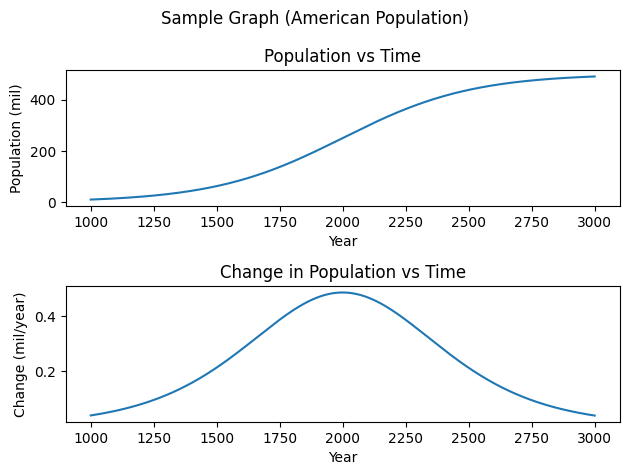

In [7]:
# None of these values are intended to be historically correct, they are choosen
# purely to make the graph look nice

k_america = 500_000_000 / 1_000_000 # in millions
init_pop_america = 10_000_000 / 1_000_000 # in millions

time_america, pop_america, d_pop_america = \
    make_pop_data(b_america, d_america, init_pop_america, k_america, 1000, 3000)

fig1, (fig1_ax1, fig1_ax2) = plt.subplots(2)

fig1.suptitle("Sample Graph (American Population)")

fig1_ax1.plot(time_america, pop_america)
fig1_ax1.set_title("Population vs Time")
fig1_ax1.set_xlabel("Year")
fig1_ax1.set_ylabel("Population (mil)")

fig1_ax2.plot(time_america, d_pop_america)
fig1_ax2.set_title("Change in Population vs Time")
fig1_ax2.set_xlabel("Year")
fig1_ax2.set_ylabel("Change (mil/year)")

fig1.tight_layout()


The next task is to find $r$ for civilizations in the Universe, as this is the
model that works best for the Universe. This is also the last unknown needed
before a graph can be made, since $P_0 = 1$ and $t = 0$ is -5000 Ma (which will
go to the present time or a bit past it). There is really no way to estimate
what this may be, and all that really matters is that the graph looks nice. So
multiple $r$ values will be graphed to see what looks best.

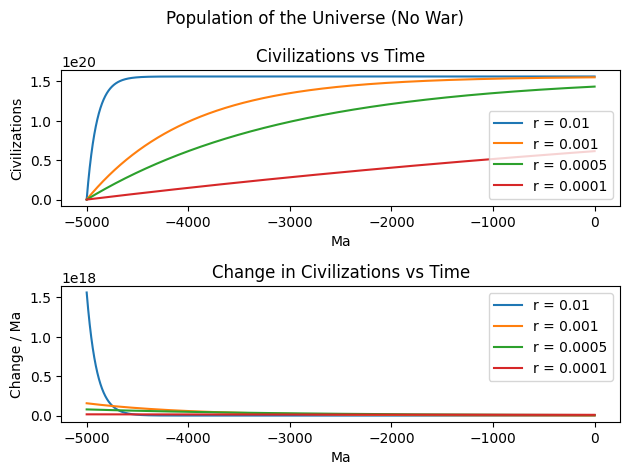

In [8]:
# Possible rates at which all remaining planets become civilized / Ma
r1 = 0.01
r2 = 0.001
r3 = 0.0005
r4 = 0.0001

time1, pop1, d_pop1 = \
    make_civ_data(r1, init_pop, k_civ, init_time, 0)
time2, pop2, d_pop2 = \
    make_civ_data(r2, init_pop, k_civ, init_time, 0)
time3, pop3, d_pop3 = \
    make_civ_data(r3, init_pop, k_civ, init_time, 0)
time4, pop4, d_pop4 = \
    make_civ_data(r4, init_pop, k_civ, init_time, 0)

fig2, (fig2_ax1, fig2_ax2) = plt.subplots(2)

fig2.suptitle("Population of the Universe (No War)")

fig2_ax1.plot(time1, pop1, label=str(f"r = {r1}"))
fig2_ax1.plot(time2, pop2, label=str(f"r = {r2}"))
fig2_ax1.plot(time3, pop3, label=str(f"r = {r3}"))
fig2_ax1.plot(time4, pop4, label=str(f"r = {r4}"))
fig2_ax1.set_title("Civilizations vs Time")
fig2_ax1.set_xlabel("Ma")
fig2_ax1.set_ylabel("Civilizations")
fig2_ax1.legend()

fig2_ax2.plot(time1, d_pop1, label=str(f"r = {r1}"))
fig2_ax2.plot(time2, d_pop2, label=str(f"r = {r2}"))
fig2_ax2.plot(time3, d_pop3, label=str(f"r = {r3}"))
fig2_ax2.plot(time4, d_pop4, label=str(f"r = {r4}"))
fig2_ax2.set_title("Change in Civilizations vs Time")
fig2_ax2.set_xlabel("Ma")
fig2_ax2.set_ylabel("Change / Ma")
fig2_ax2.legend()

fig2.tight_layout()


The best of these seems to be $r=0.001$, so from here on, the rate at which
planets become civilizations per million years is 0.1%. Now, to calculate Picker
times, which is the entire point of this model, death rates must be found. It
can be assumed that each civilization, once at the carrying capacity, has a
natural, equal birth and death rate. Since the number of civilizations can be
calculated at anytime, the total death rate can too. Finding the total
population of the universe from the number of civilizations and multiplying that
by the death rate gives the number of deaths in any period of time.

Continuing to ignore the Transcendentalists' War, where $P$ is the number of
civilizations in the Universe at any given time, the death rate can be
calculated as,

$$ \frac{\mathrm{d}D}{\mathrm{d}t} = dK_{world}P(t) $$

$$ \frac{\mathrm{d}D}{\mathrm{d}t} = dK_{world}\left(\frac{P_0 K e^{rt}}{(K-P_0)
+ P_0 e^{rt}}\right) $$

The death rate in America, as used earlier, is $r = 0.0084$ per year, or 0.84%.
This can be used as the natural death rate of all civilizations in the Universe
at carrying capacity.

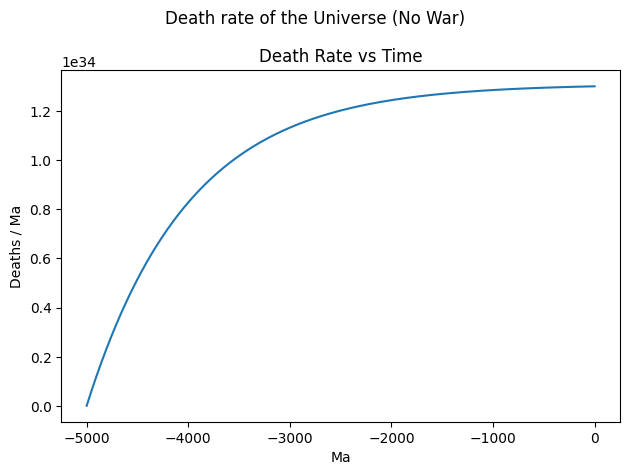

In [9]:
# Taking the choosen r value data
time = time2
pop = pop2
d_pop = d_pop2

d = 0.0084 # per year
d = d*1_000_000 # per Ma

death_rate = pop*k_world*d

fig3, fig3_ax1 = plt.subplots()

fig3.suptitle("Death rate of the Universe (No War)")

fig3_ax1.plot(time, death_rate)
fig3_ax1.set_title("Death Rate vs Time")
fig3_ax1.set_xlabel("Ma")
fig3_ax1.set_ylabel("Deaths / Ma")

fig3.tight_layout()




### Relative Picker Time

The average relative Picker time between two times $t_0$ and $t_1$ is simply,

$$ R = \frac{(t_1-t_0)-(H(t_1)-H(t_0))}{D(t_1)-D(t_0)} $$

where the total time (minus the time taken up in the period $t_0$ to $t_1$ by
the Harolds) divided by the number of deaths gives the amount of time per death,
or in between deaths. This is the minimum time each person must be Picker for
all moments in time to have a Picker.

To calculate the "instantenous" Picker time, the following limit is set up,

$$ R(t) = \lim_{t_1 \to t} \frac{t_1-t-H(t_1)-H(t)}{D(t_1)-D(t)} $$

Solving the limit using the definition of the derivative,

$$ R(t) = \lim_{t_1 \to t} \frac{(t_1-t)
\left(1-\frac{H(t_1)-H(t)}{t_1-t}\right)}{D(t_1)-D(t)} $$

$$ R(t) = \lim_{t_1 \to t} \frac{(t_1-t)(1-H'(t))}{D(t_1)-D(t)} $$

$$ R(t) = \lim_{t_1 \to t}
\frac{1-H'(t)}{\left(\frac{D(t_1)-D(t)}{t_1-t}\right)} $$

$$ R(t) = \lim_{t_1 \to t} \frac{1-H'(t)}{D'(t)} $$

$$ R(t) = \frac{1-H'(t)}{D'(t)} $$

But due to the low number of Harolds,

$$ R(t) \approx \frac{1}{D'(t)} $$

### Absolute Picker Time

To convert from relative to absolute Picker time, the equation

$$ A(t) = \gamma R(t) $$

is used where $\gamma$ is the time factor. This means that, for every second in
the real world, the Picker experiences $\gamma$ seconds. Due to the nature of
the Picker's job, this time factor is massive, leading to the tongue-in-cheek
definition of the Picker's job as Hell. The approximation (ignoring relativity)
for $\gamma$ is given by,

$$ \gamma = nT $$

where $n$ is the number of required Picker operations per second and $T$ is the
time per Picker operation.

### Rate of Change of the Absolute Picker Time and Death Rate

The next task is to calculate $A'(t)$, as this is why (Super-)Choosers exist.
The equation for the change in Picker time is simply (ignoring the Harolds),

$$ A(t) = \gamma D'(t)^{-1} $$

$$ A'(t) = -\gamma D'(t)^{-2}\,D''(t) $$

Since Changers, in order to "reduce" the Picker time, influence the death rate,
we should also calculate $D''(t)$ by rearranging the equation for $A(t)$,

$$ A(t) = \gamma D'(t)^{-1} $$

$$ D'(t) = \gamma A(t)^{-1} $$

$$ D''(t) = -\gamma A'(t)A(t)^{-2} $$

But, if we assume $A'(t)$ is a constant $a$, then,

$$ D''(t) = -\gamma \,a A(t)^{-2} $$

Then, using the accumulation of the rate of change,

$$ D''(t) = -\gamma \,a \left(\int A'(t)\,dt\right)^{-2} $$

$$ D''(t) = -\gamma \,a \left(\int a\,dt\right)^{-2} $$

$$ D''(t) = -\gamma \,a (at + C)^{-2} $$

$C$ is simply the inital Picker time, which for ease of calculations can be the
value of Picker time at *any choosen time*. So, the equation for the rate of
change of the death rate is,

$$ D''(t) = -\gamma \,\frac{a}{(at+A_0)^2} $$

But if we assume $A'(t)$ is some function $f(t)$, then,

$$ D''(t) = -\gamma \,\frac{f(t)}{(F(t)+A_0)^2} $$

### Numerical Calculations for Gamma

(To the educated people reading this, suspend your disbelief for a minute, so I
can have some fun.)

For the story, to calculate $\gamma$, we will start by finding a $D'$ around the
21st century, $t=0$, (prior to the close of the Transcendentalists' War). From
this we can calculate $A$. Since all sentient beings, including aliens, become
Pickers, the population of the entire Universe must be calculated.

Stealing results from
[Wikipedia](https://en.wikipedia.org/wiki/Drake_equation#Range_of_results), we
can see that there may be 15,600,000 civilizations in our galaxy. Since these
civilizations have the technology to communicate into space, it must be assumed
that they have similar populations to Earth (around 10 billion). Expanding our
galaxy's estimate to all stars in the Universe,
[$10^{24}$](https://www.space.com/26078-how-many-stars-are-there.html); and by
getting the ratio of stars (using the Milky Way, $mw$, as reference) with
sentient life by dividing the number of civilizations from the total number of
stars in our galaxy, [$10^{11}$](https://en.wikipedia.org/wiki/Milky_Way), there
are,

$$ P = \bar P_{world} \cdot n_{stars} \cdot
\left(\frac{n_{civs}}{n_{stars}}\right)_{mw} $$

$$ 1.560\times10^{30} = 10^{10} \times 10^{24} \times \frac{1.560 \times
10^7}{10^{11}} $$

sentient beings in the Universe.

Assuming that 0.05% of sentient beings die each year (around Earth's death
rate), completely ignoring the rate of change for now, there are $7.8 \times
10^{26}$ deaths every year. Converting to the proper units (percent which die
every second), $D'(t) = 2.473 \times 10^{19}$ deaths per second.

Ignoring Harolds' Time,

$$ R = \left(2.473 \times 10^{19}\right)^{-1} $$

$$ R = 4.044 \times 10^{-20} $$

Or, in attoseconds, $R = 0.04044$. From this, we can set up the equation $A =
\gamma R$ and solve for a reasonable $\gamma$ based of the narrative
requirements of a reasonable Picker time. 10,000 years is good, and so,
converting to seconds,

$$ 3.153 \times 10^{11} = \gamma\,4.044 \times 10^{-20}$$

$$ \gamma = 7.798 \times 10^{30} $$

I may later justify this $\gamma$ using some values for $n$ and $T$. But for
now, $\gamma$ is simply *given* by the Pickers through their Oracles.

### Numerical Calculations for Changers

To see the effect Changers have on the Picker time by adding, say, 10 billion
extra deaths in *any given* second (caused by a Changer destroying the entire
Earth instantaneously somehow), we can calculate a difference,

$$ A_1 - A_2 \approx \text{diff} $$

where $A_1$ is what was calculated previously for the Picker time prior to the
end of the Transcendentalists' War and $A_2$ is the *new* value for the Picker
time based on the new death rate, which is just $D'_1$ plus the added deaths
from a Changer killing billions, $D'_2$. Plugging in numbers,

$$ 3.153 \times 10^{11} - \left(7.798 \times 10^{30}\right)\left(\left(2.473
\times 10^{19}\right) + 10^{10}\right)^{-1} \approx 127 \;\text{seconds}$$

### Numerical Calculations for the Transcendentalists' War

Now a reasonable decrease in the death rate (more specifically, the rate of
change of this decrease) as the Transcendentalists' War came to a close can be
calculated. Choosers emerged when the Oracles gave news of a drastic increase in
the Picker time from the consistent 10,000 years. Every year, the new Picker
time was 100 years greater. This means that the rate of change of $A$ is 100
seconds per second. So, to calculate $D''(t)$,

$$ D''(t) = -\gamma \,\frac{a}{(at+A_0)^2} $$

$$ D''(t) = \frac{-(7.798 \times 10^{30})100}{(100t+3.1536 \times 10^{11})^2} $$

At the very beginning of the end of the Transcendentalists' War, the change in
the death was, then,

$$ \frac{-(7.798 \times 10^{30})100}{(100(0)+3.1536 \times 10^{11})^2} = -7.841
\;\text{billion}/s^{2} $$

So, as the Transcendentalists' War comes to a close, the death rate decreased by
around 8 billion deaths (1 worlds) per second squared. Plotting this,